In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy.signal import get_window
import glob
import time

#dBu = 20log10(V/0.775V)
#The FFT assumes that the signal is periodic and continuous within the window. 
#If the signal is not perfectly periodic, it can cause spectral leakage, which results in an offset or differences in the frequency spectrum.
def rfft(y, cnv): #this function computes the fft of y
    window = get_window("hanning", len(y))
    y_windowed = y * window
    
    N = len(y)

    Y = fft.rfft(y_windowed)
    Y_normalized = np.abs(Y) / N
    Y_dBu = 20*(np.log10(np.abs(Y_normalized)) * cnv / 0.775)
    
    return Y_dBu

def rffts(ys): #the imput are 2d arrays bc this function computes multiple ffts
    window = get_window("hanning", ys.shape[1])
    #window = np.ones(ys.shape[1])
    #print(window.shape)
    #print(ys.shape)

    ys_windowed = ys * window[np.newaxis, :]

    N = len(ys)

    Ys = fft.rfft(ys_windowed, axis = 1) / N
    
    return Ys

def mean_wf(all_amplitudes):
    avg_wf = np.mean(all_amplitudes, axis=0) #weights are all the same

    return avg_wf

def mean_fft(all_ffts, cnv):
    avg_fft = np.mean(all_ffts, axis = 0)
    print(f"avg fft: {avg_fft}")
    avg_fft_dBu = 20*(np.log10(np.abs(avg_fft)) * cnv / 0.775)
    
    return avg_fft_dBu

# def mean_fft(all_magnitudes, all_errors):
#     B = np.mean(all_magnitudes, axis = 0) #weights are all the same

#     stat_stds = np.std(all_magnitudes, axis = 0)
#     weights = 1/all_errors**2
#     print(f"check if all weights are the same or not: {weights}, if not, come to mean_fft and change the first line into a weighted mean")
#     syst_stds = np.sqrt(1/weights.sum(axis = 0))
    
#     stds_fft = np.sqrt(stat_stds**2 + syst_stds**2)
#     return B, stds_fft

In [2]:
hour = '15.42'
day = '08082024'

# FFT of the average of the waveforms

### compute and plot the average of the waveforms

In [4]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list_A = []

for i, file in enumerate(file_list):
    df = pd.read_csv(file)
    if i == 0:
        print(df.iloc[:, 0])
        print(df.iloc[:, 1])
        times_A = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
    amplitudes_A = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
    amplitudes_list_A.append(amplitudes_A)
    
#print(amplitudes_list)

all_amplitudes_A = np.stack(amplitudes_list_A, axis = 0)

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -1.96850400
2        -1.57480300
3        -1.18110200
4        -0.78740150
            ...     
62500     0.00000000
62501     0.39370070
62502    -0.39370070
62503    -1.18110200
62504    -1.18110200
Name: Channel D, Length: 62505, dtype: object


In [5]:
#The ADC of the Picoscope only represents discrete levels of input voltage in 8 bit resolution
conversion_factor = 0.001

amplitudes_avg = mean_wf(all_amplitudes_A)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


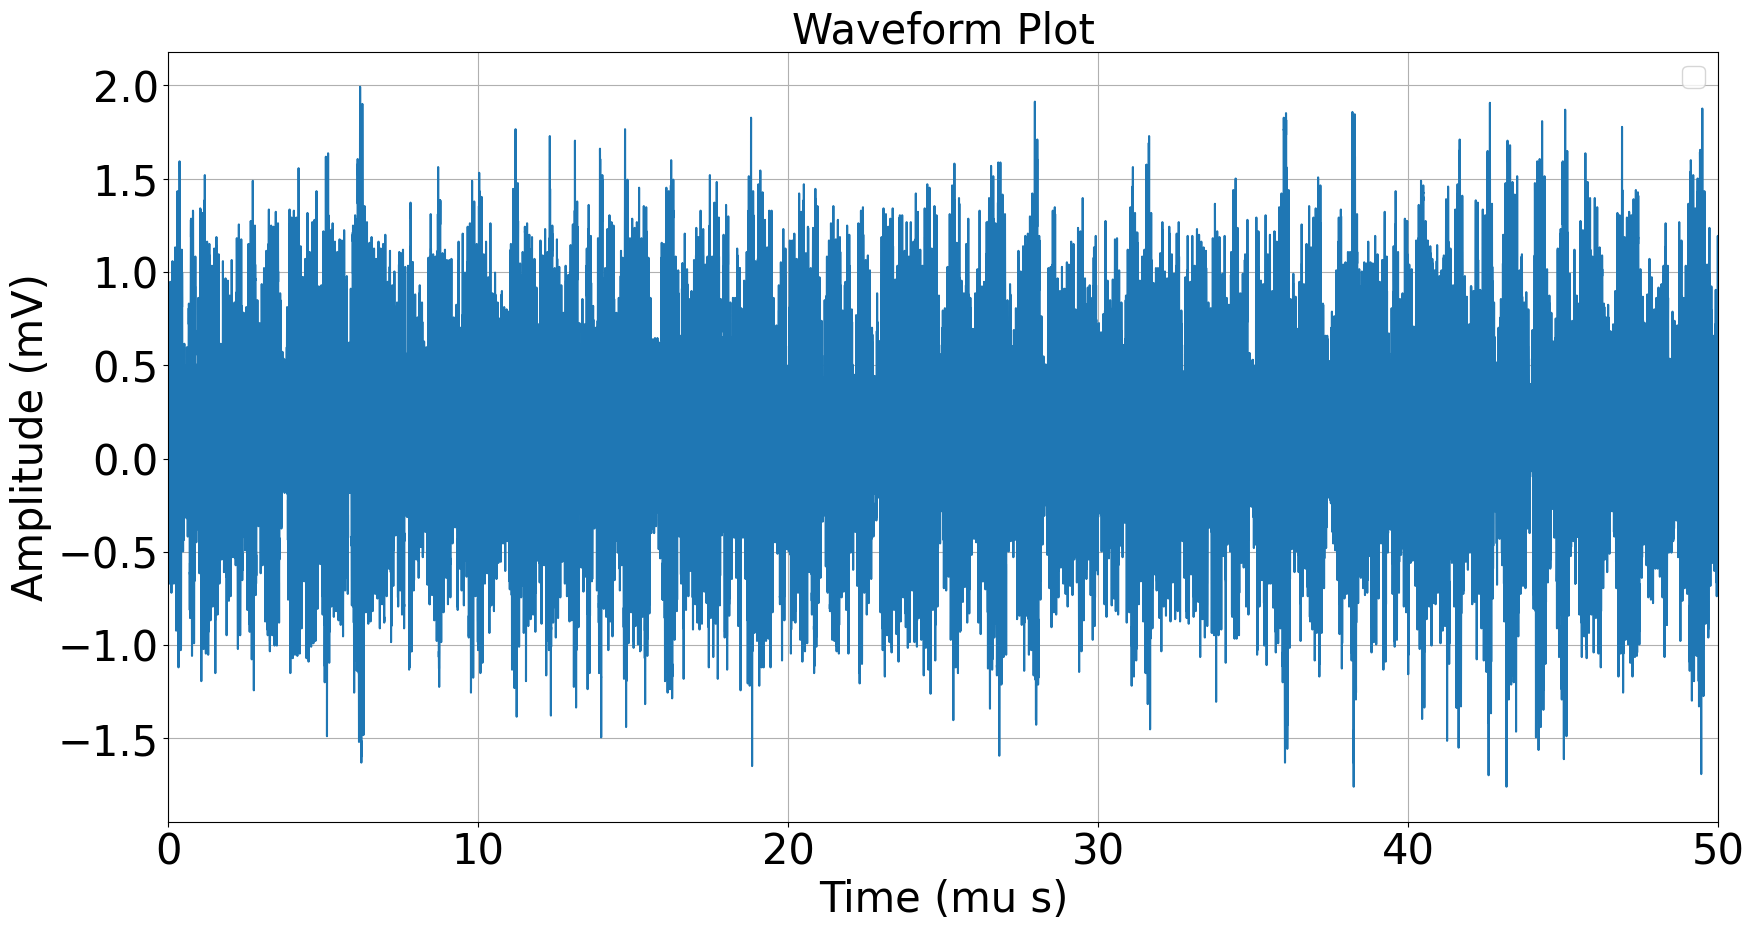

In [7]:
plt.figure(figsize=(20, 10))
#plt.errorbar(times, amplitudes_avg, yerr=amplitudes_avg_errors, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1, label = f"{hour}_{day}")
plt.plot(times_A, amplitudes_avg)
plt.title('Waveform Plot', fontsize = 30)
plt.xlabel('Time (mu s)', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude (mV)', fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(loc = "best",  prop={'size': 20})
plt.grid(True)
plt.xlim(0, 50)
plt.show()

### compute and plot the fft of the avg of the waveforms

f_s = 1250.0199822905822


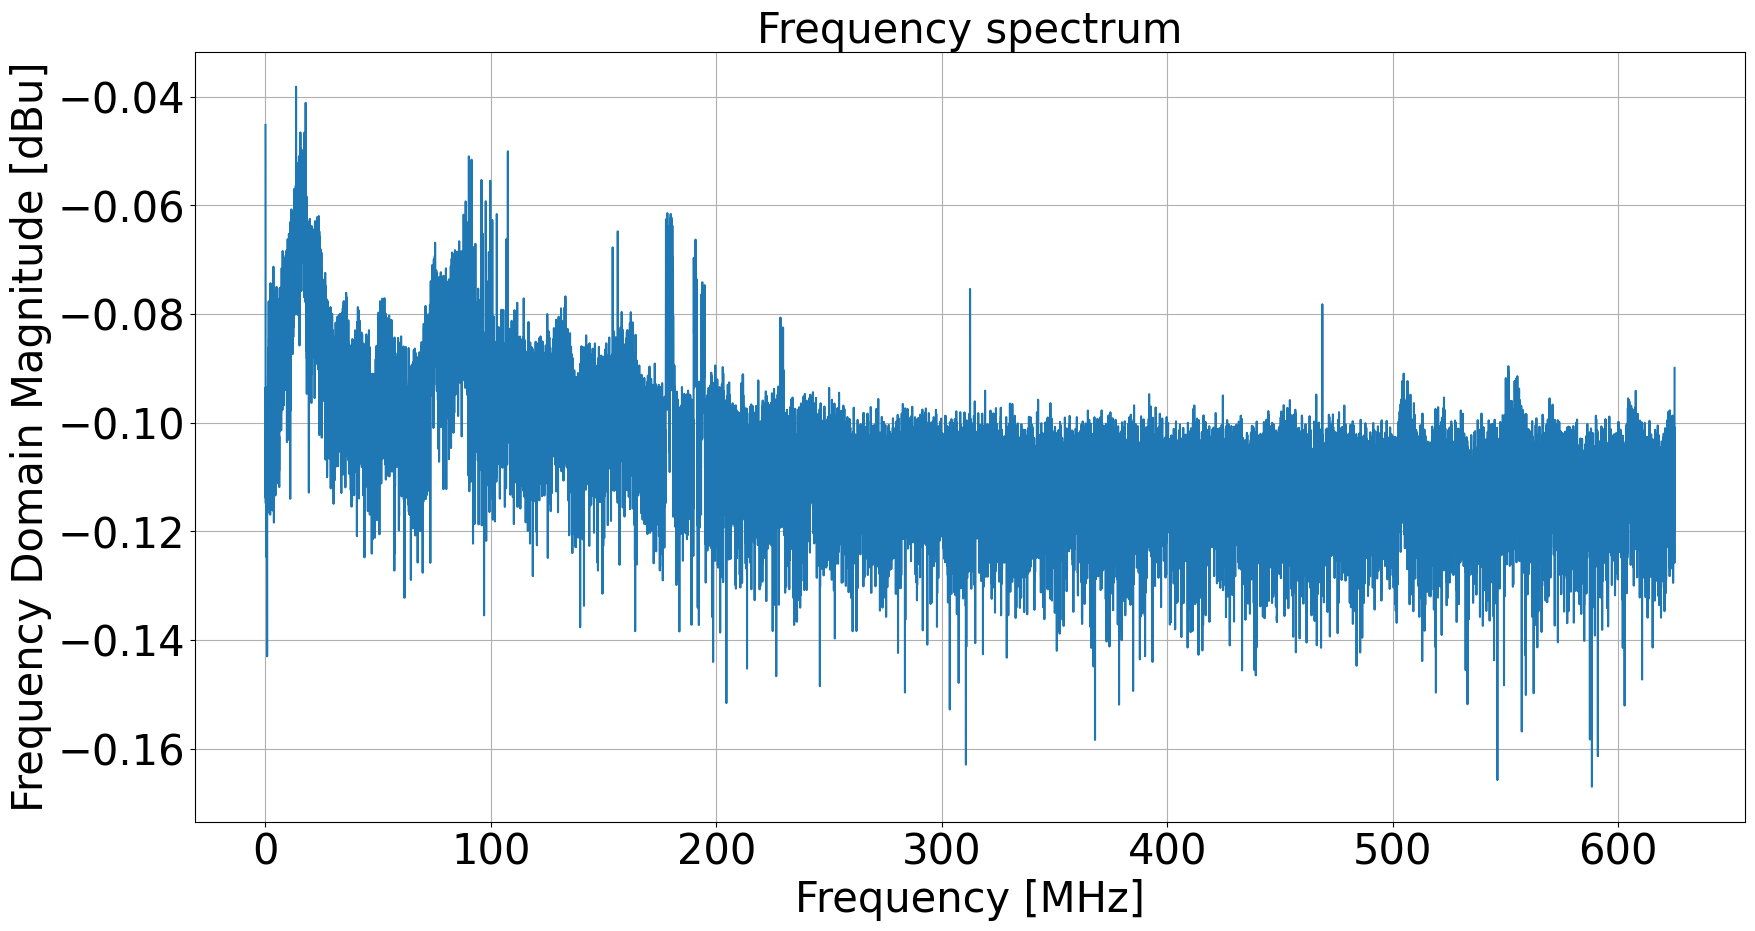

Execution time: 0.5505077838897705 seconds


In [ ]:
span_A = times_A[len(times_A)-1] 
f_s = len(times_A) / span_A
print(f"f_s = {f_s}")
freqs_A = fft.rfftfreq(len(amplitudes_avg), 1/f_s) #window lenght, sample spacing

#plot the fft and see how much time it takes
start_time = time.time()

Y_dBu = rfft(amplitudes_avg, conversion_factor)

plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, Y_dBu, yerr = Y_err_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_A, Y_dBu)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()
plt.show()

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# Method B: Average of the FFTs

In [ ]:
file_pattern_wfs = f"../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list_wfs = glob.glob(file_pattern_wfs)

amplitudes_list_B = []


if not file_list_wfs:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list_wfs):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times_B = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes_B = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list_B.append(amplitudes_B)
        
all_amplitudes_B = np.stack(amplitudes_list_B, axis = 0)

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -7.08661400
2        -6.69291300
3        -6.29921200
4        -6.29921200
            ...     
62500    -6.69291300
62501    -6.69291300
62502    -6.69291300
62503    -6.69291300
62504    -6.69291300
Name: Channel D, Length: 62505, dtype: object


In [ ]:
conversion_factor = 0.001


### compute the FFTs

In [ ]:
Ys = rffts(all_amplitudes_B)

### compute and plot the mean of the FFTs

In [ ]:
avg_fft_dBu = mean_fft(Ys, conversion_factor)

avg fft: [-1.73124484e+01+0.j          8.66160306e+00+0.32119423j
  9.65821189e-02-0.21370846j ...  1.53616800e-02+0.04352894j
  1.54247498e-01-0.05388811j -3.20066112e-01+0.j        ]


f_s = 1250.0199822905822


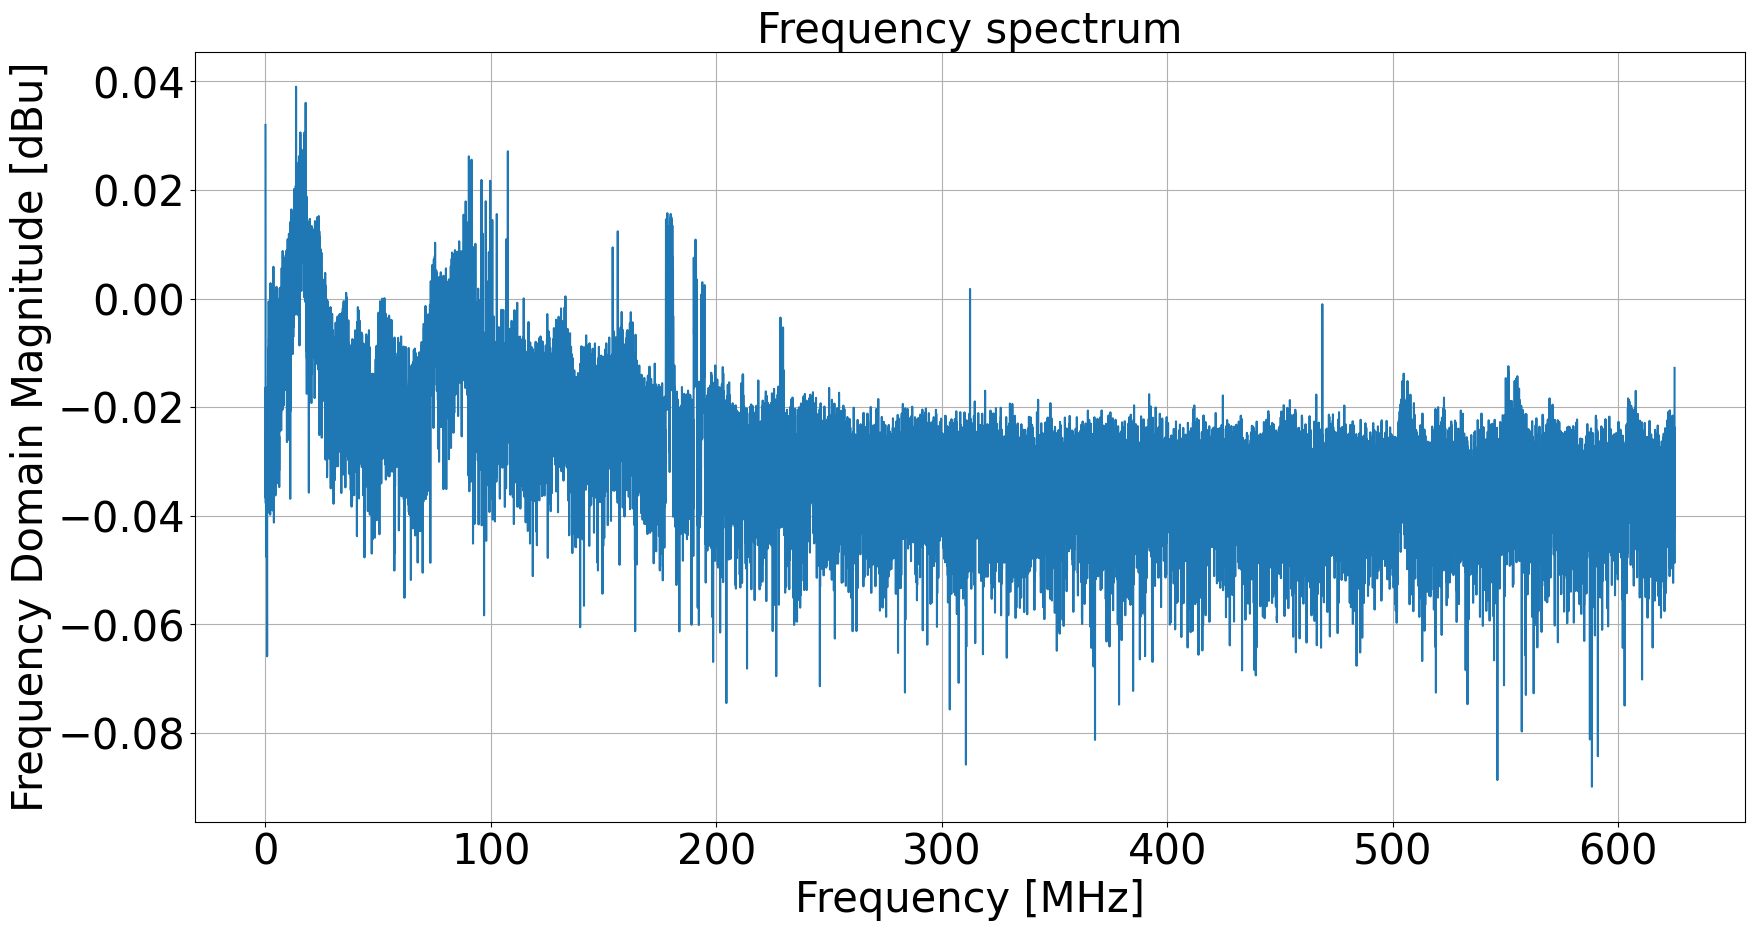

In [ ]:
span_B = times_B[len(times_B)-1] 
f_s = len(times_B) / span_B
print(f"f_s = {f_s}")
freqs_B = fft.rfftfreq(all_amplitudes_B.shape[1], 1/f_s) #window lenght, sample spacing


plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, B_dBu, yerr = stds_fft_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_B, avg_fft_dBu)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()


# Comparison between the two

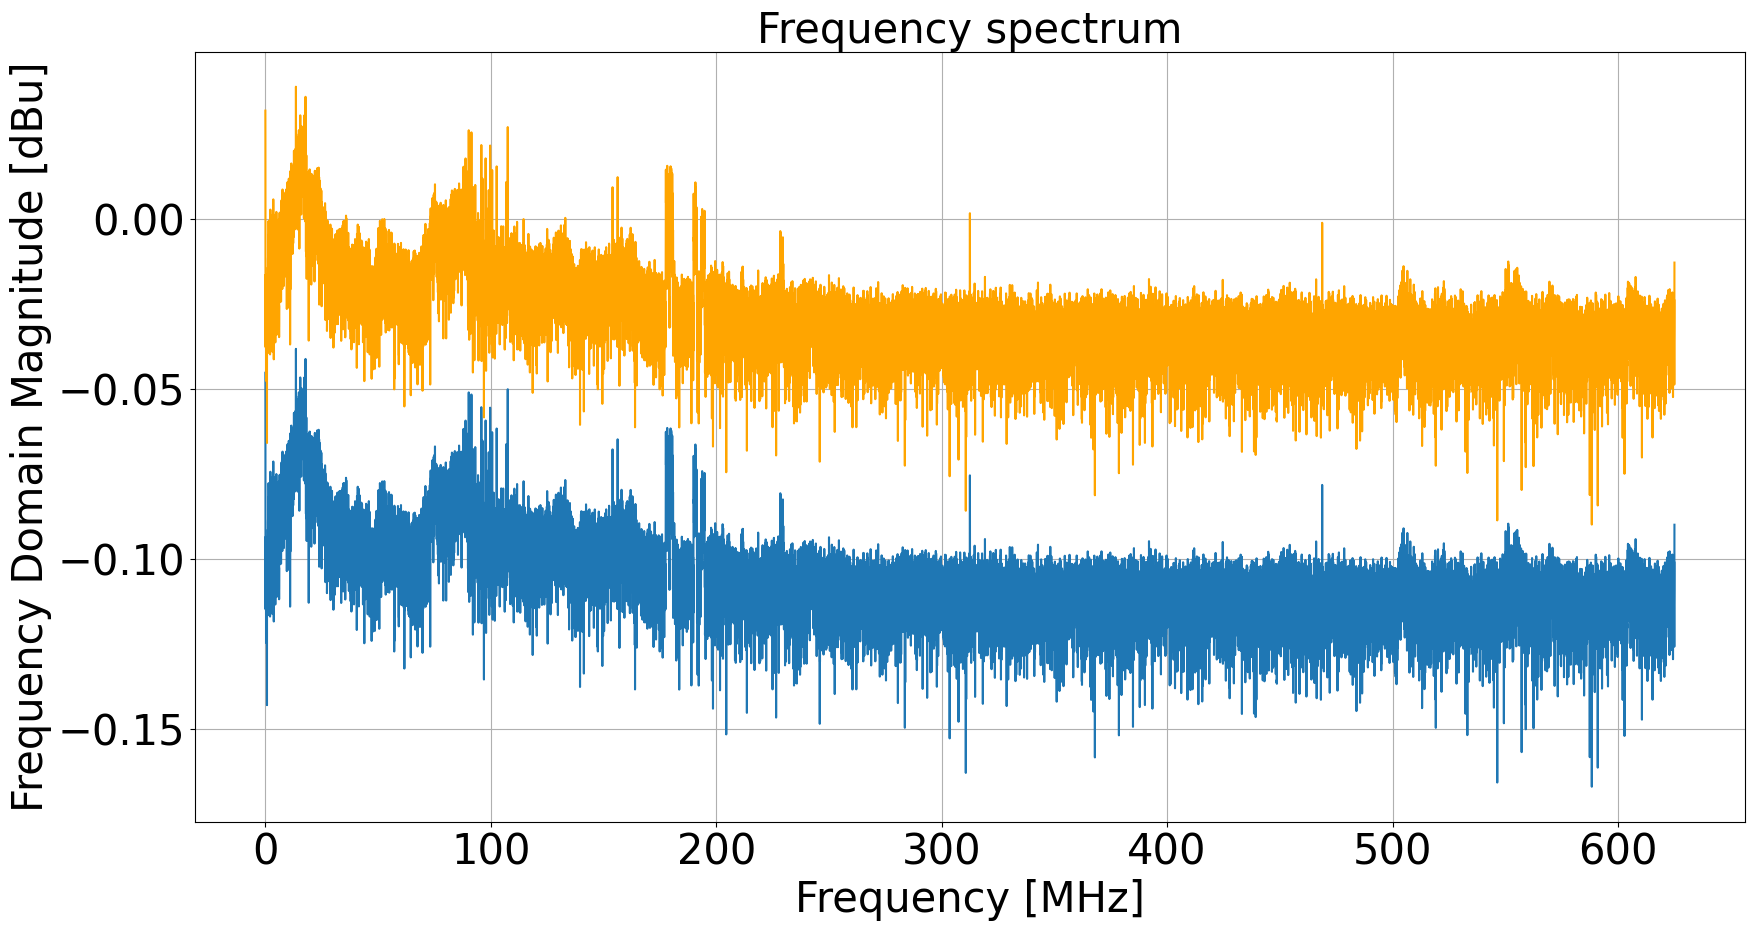

In [ ]:
plt.figure(figsize=(20, 10))

#plt.errorbar(freqs, Y_dBu, yerr = Y_err_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_A, Y_dBu)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()

#---------------------------------------------------------------
#plt.errorbar(freqs, avg_fft_dBu, yerr = stds_fft_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_B, avg_fft_dBu, color = 'orange')
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [ ]:
offset_blue = np.mean(Y_dBu[(freqs_A >= 250) & (freqs_A <= 350)])
offset_orange = np.mean(avg_fft_dBu[(freqs_B >= 250) & (freqs_B <= 350)])
print(f"offset blue: {offset_blue} - offset orange: {offset_orange} = {offset_blue - offset_orange}")
diff = offset_blue - offset_orange 

offset blue: -0.11030903196032454 - offset orange: -0.03315476519083725 = -0.07715426676948729


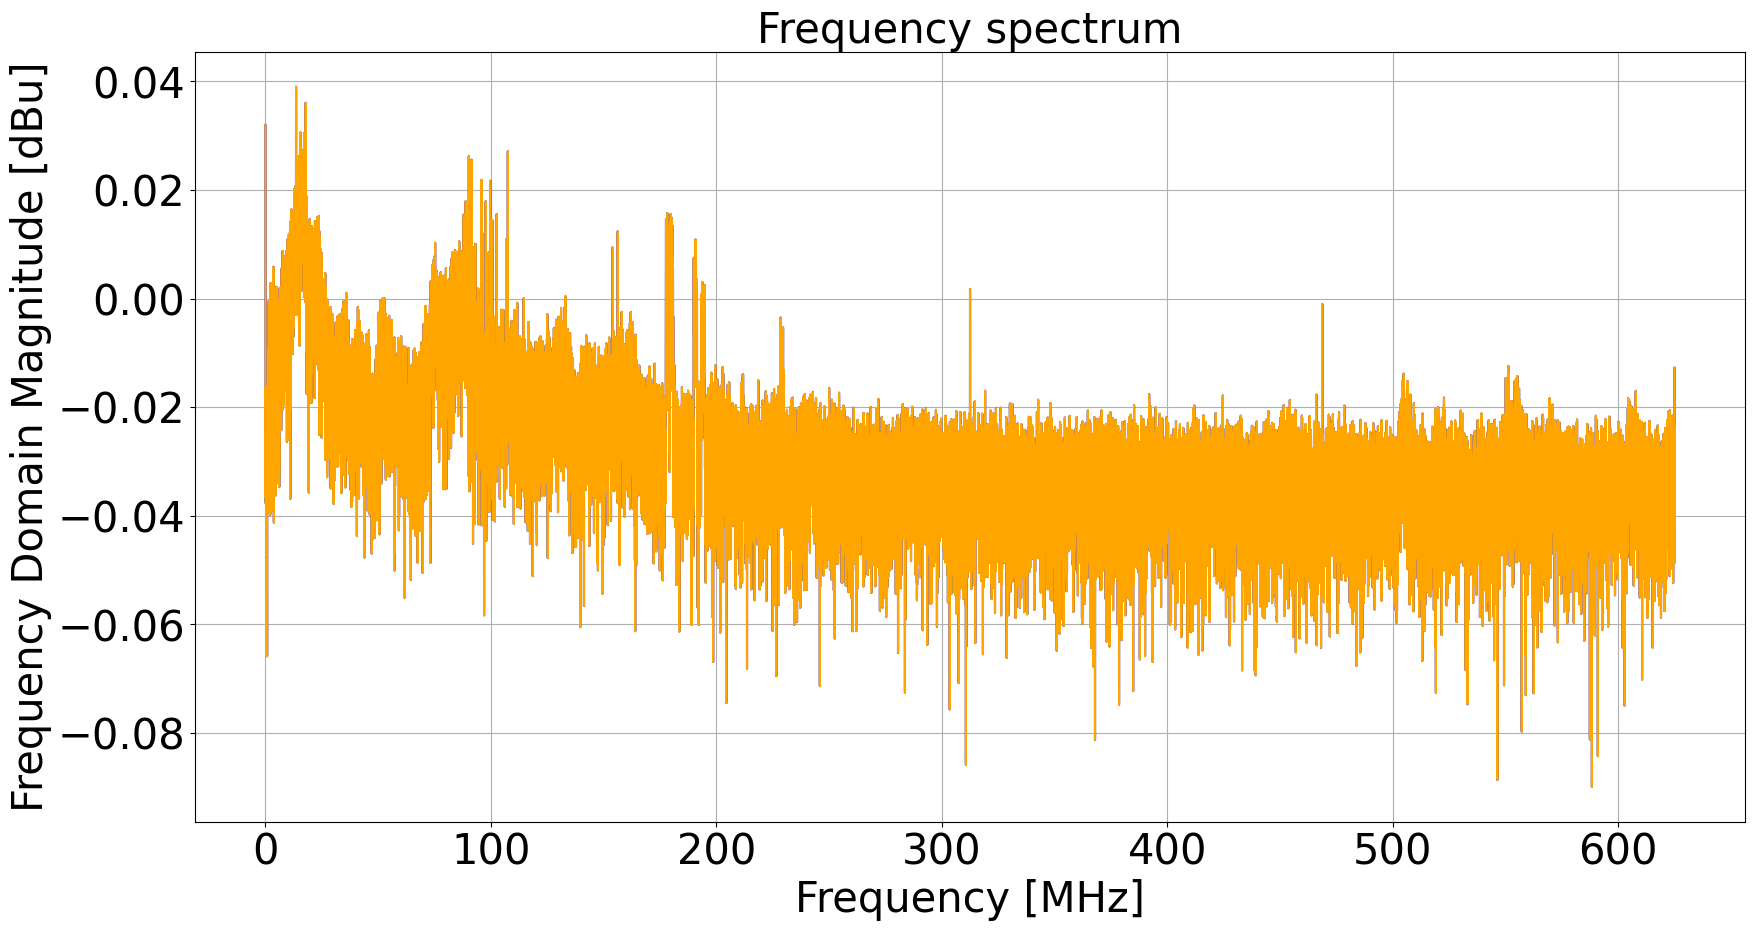

In [ ]:
plt.figure(figsize=(20, 10))

#plt.errorbar(freqs, Y_dBu, yerr = Y_err_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_A, Y_dBu - diff, color = 'blue')

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()

#---------------------------------------------------------------

#plt.errorbar(freqs, B_dBu, yerr = stds_fft_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_B, avg_fft_dBu, color = 'orange')

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()